# Segmentation

Image segmentation is another early as well as an important image processing task. Segmentation is the process of breaking an image into groups, based on similarities of the pixels. Pixels can be similar to each other in multiple ways like brightness, color, or texture. The segmentation algorithms are to ﬁnd a partition of the image into sets of similar pixels which usually indicating objects or certain scenes in an image.

The segmentations in this chapter can be categorized into two complementary ways: one focussing on detecting the boundaries of these groups, and the other on detecting the groups themselves, typically called regions. We will introduce some principles of some algorithms in this notebook to present the basic ideas in segmentation.

## Probability Boundary Detection

A boundary curve passing through a pixel $(x,y)$ in an image will have an orientation $\theta$, so we can formulize boundary detection problem as a classification problem. Based on features from a local neighborhood, we want to compute the probability $P_b(x,y,\theta)$ that indeed there is a boundary curve at that pixel along that orientation. 

One of the sampling ways to calculate $P_b(x,y,\theta)$ is to generate a series sub-divided into two half disks by a diameter oriented at θ. If there is a boundary at (x, y, θ) the two half disks might be expected to differ signiﬁcantly in their brightness, color, and texture. For detailed proof of this algorithm, please refer to this [article](https://people.eecs.berkeley.edu/~malik/papers/MFM-boundaries.pdf).

### Implementation

We implemented a simple demonstration of probability boundary detector as `probability_contour_detection` in `perception.py`. This method takes three inputs:

- image: an image already transformed into the type of numpy ndarray.
- discs: a list of sub-divided discs.
- threshold: the standard to tell whether the difference between intensities of two discs implying there is a boundary passing the current pixel.

we also provide a helper function `gen_discs` to gen a list of discs. It takes `scales` as the number of sizes of discs will be generated which is default 1. Please note that for each scale size, there will be 8 sub discs generated which are in the horizontal, verticle and two diagnose directions. Another `init_scale` indicates the starting scale size. For instance, if we use `init_scale` of 10 and `scales` of 2, then scales of sizes of 10 and 20 will be generated and thus we will have 16 sub-divided scales.

### Example

Now let's demonstrate the inner mechanism with our navie implementation of the algorithm. First, let's generate some very simple test images. We already generated a grayscale image with only three steps of gray scales in `perceptron.py`:

In [2]:
import os, sys
sys.path = [os.path.abspath("../../")] + sys.path
from perception4e import *
from notebook4e import *
import matplotlib.pyplot as plt

Using TensorFlow backend.


Let's take a look at it:

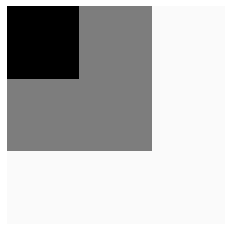

In [8]:
plt.imshow(gray_scale_image, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

You can also generate your own grayscale images by calling `gen_gray_scale_picture` and pass the image size and grayscale levels needed:

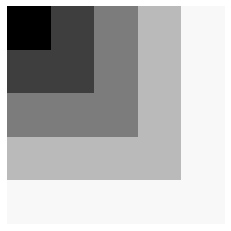

In [10]:
gray_img = gen_gray_scale_picture(100, 5)
plt.imshow(gray_img, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

Now let's generate the discs we are going to use as sampling masks to tell the intensity difference between two half of the care area of an image. We can generate the discs of size 100 pixels and show them:

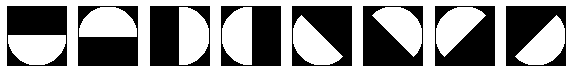

In [29]:
discs = gen_discs(100, 1)
fig=plt.figure(figsize=(10, 10))
for i in range(8):
    img = discs[0][i]
    fig.add_subplot(1, 8, i+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

The white part of disc images is of value 1 while dark places are of value 0. Thus convolving the half-disc image with the corresponding area of an image will yield only half of its content. Of course, discs of size 100 is too large for an image of the same size. We will use discs of size 10 and pass them to the detector.

In [44]:
discs = gen_discs(10, 1)
contours = probability_contour_detection(gray_img, discs[0])

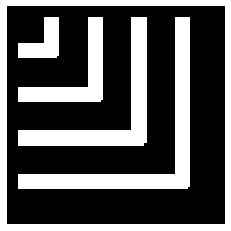

In [45]:
show_edges(contours)

As we are using discs of size 10 and some boundary conditions are not dealt with in our naive algorithm, the extracted contour has a bold edge with missings near the image border. But the main structures of contours are extracted correctly which shows the ability of this algorithm.

## Group Contour Detection

The alternative approach is based on trying to “cluster” the pixels into regions based on their brightness, color and texture properties. There are multiple grouping algorithms and the simplest and the most popular one is k-means clustering. Basically, the k-means algorithm starts with k randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative calculations to optimize the positions of the centroids. For a detailed description, please refer to the chapter of unsupervised learning.

### Implementation

Here we will use the module of `cv2` to perform K-means clustering and show the image. To use it you need to have `opencv-python` pre-installed. Using `cv2.kmeans` is quite simple, you only need to specify the input image and the characters of cluster initialization. Here we use modules provide by `cv2` to initialize the clusters. `cv2.KMEANS_RANDOM_CENTERS` can randomly generate centers of clusters and the cluster number is defined by the user.

`kmeans` method will return the centers and labels of clusters, which can be used to classify pixels of an image. Let's try this algorithm again on the small grayscale image we imported:

In [53]:
contours = group_contour_detection(gray_scale_image, 3)

Now let's show the extracted contours:

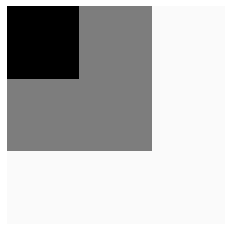

In [6]:
show_edges(contours)

It is not obvious as our generated image already has very clear boundaries. Let's apply the algorithm on the stapler example to see whether it will be more obvious:

In [39]:
import numpy as np
import matplotlib.image as mpimg

stapler_img = mpimg.imread('images/stapler.png', format="gray")

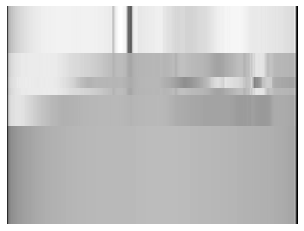

In [50]:
contours = group_contour_detection(stapler_img, 5)
plt.axis('off')
plt.imshow(contours, cmap="gray")

The segmentation is very rough when using only 5 clusters. Adding to the cluster number will increase the degree of subtle of each group thus the whole picture will be more alike the original one:

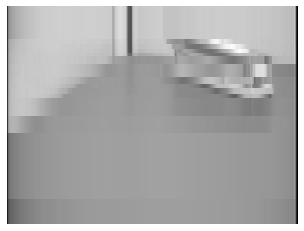

In [51]:
contours = group_contour_detection(stapler_img, 15)
plt.axis('off')
plt.imshow(contours, cmap="gray")

## Minimum Cut Segmentation

Another way to do clustering is by applying the minimum cut algorithm in graph theory. Roughly speaking, the criterion for partitioning the graph is to minimize the sum of weights of connections across the groups and maximize the sum of weights of connections within the groups.

### Implementation

There are several kinds of representations of a graph such as a matrix or an adjacent list. Here we are using a util function `image_to_graph` to convert an image in ndarray type to an adjacent list. It is integrated into the class of `Graph`. `Graph` takes an image as input and offer the following implementations of some graph theory algorithms:

- bfs: performing bread searches from a source vertex to a terminal vertex. Return `True` if there is a path between the two nodes else return `False`.

- min_cut: performing minimum cut on a graph from a source vertex to sink vertex. The method will return the edges to be cut.

Now let's try the minimum cut method on a simple generated grayscale image of size 10:

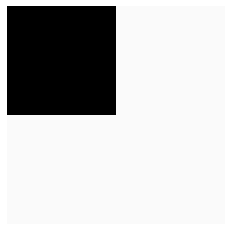

In [67]:
image = gen_gray_scale_picture(size=10, level=2)
show_edges(image)

In [66]:
graph = Graph(image)
graph.min_cut((0,0), (9,9))

[((0, 4), (0, 5)),
 ((1, 4), (1, 5)),
 ((2, 4), (2, 5)),
 ((3, 4), (3, 5)),
 ((4, 0), (5, 0)),
 ((4, 1), (5, 1)),
 ((4, 2), (5, 2)),
 ((4, 3), (5, 3)),
 ((4, 4), (5, 4)),
 ((4, 4), (4, 5))]

There are ten edges to be cut. By cutting the ten edges, we can separate the pictures into two parts by the pixel intensities.